In [2]:
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import statsmodels.api as sm
import numpy as np
import pandas as pd

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor


In [4]:
flights = pd.read_csv("../../sample_project/FlightDelays.csv")
flights.head(10)

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime
5,840,DH,839,JFK,228,01/01/2004,7800,IAD,0,4,1,N687BR,ontime
6,1240,DH,1243,JFK,228,01/01/2004,7806,IAD,0,4,1,N321UE,ontime
7,1645,DH,1644,JFK,228,01/01/2004,7810,IAD,0,4,1,N301UE,ontime
8,1715,DH,1710,JFK,228,01/01/2004,7812,IAD,0,4,1,N328UE,ontime
9,2120,DH,2129,JFK,228,01/01/2004,7814,IAD,0,4,1,N685BR,ontime


In [5]:
flights["DEP_DIFF"] = flights["CRS_DEP_TIME"] - flights["DEP_TIME"]
flights.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,DEP_DIFF
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime,0
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime,0
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime,0
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime,6
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime,4


In [6]:
negative_difference = flights[(flights["DEP_DIFF"] < 0) & (flights["Flight Status"] == "delayed")]
negative_difference.head()

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,DEP_DIFF
53,1455,DH,1531,LGA,229,01/02/2004,7211,IAD,0,5,2,N665BR,delayed,-76
56,1039,DH,1236,LGA,229,01/02/2004,7792,IAD,0,5,2,N665BR,delayed,-197
62,2120,DH,2305,JFK,228,01/02/2004,7814,IAD,0,5,2,N657BR,delayed,-185
96,1245,DH,1350,EWR,213,01/02/2004,7303,IAD,0,5,2,N686BR,delayed,-105
97,1430,DH,1512,EWR,213,01/02/2004,7307,IAD,0,5,2,N309UE,delayed,-82


In [7]:
#negative_difference.info()
negative_difference["DEP_DIFF"].mean()

-85.57099697885197

In [8]:
negative_difference_a = flights[(flights["DEP_DIFF"] < -18)]
negative_difference_a.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328 entries, 53 to 2199
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CRS_DEP_TIME   328 non-null    int64 
 1   CARRIER        328 non-null    object
 2   DEP_TIME       328 non-null    int64 
 3   DEST           328 non-null    object
 4   DISTANCE       328 non-null    int64 
 5   FL_DATE        328 non-null    object
 6   FL_NUM         328 non-null    int64 
 7   ORIGIN         328 non-null    object
 8   Weather        328 non-null    int64 
 9   DAY_WEEK       328 non-null    int64 
 10  DAY_OF_MONTH   328 non-null    int64 
 11  TAIL_NUM       328 non-null    object
 12  Flight Status  328 non-null    object
 13  DEP_DIFF       328 non-null    int64 
dtypes: int64(8), object(6)
memory usage: 38.4+ KB


In [9]:
print("minimum")
print(negative_difference["DEP_DIFF"].min())
print()
print("maximum")
print(negative_difference["DEP_DIFF"].max())

minimum
-425

maximum
-1


# Target: Flight status
### Binary: Either delayed (1) or not delayed (0)
### Another important factor: time delayed
##### How much time must it pass before it is considered delayed?
##### Calculations suggest around 20 - 18 minutes for the flight to be considered delayed, but how do we find this?
The way we find this is by creating two columns, one that considers the time delayed AND officially delayed (column a). the second column will only consider time delayed (column b). Column a will contain absolutely 0 "on time values", but Column B will contain some "on time" values depending on the DEP_DIFF value. We want to find a value that approaches column a entries BUT does not EXCEED, therefore: finding the time value that would determine a flight to be delayed.   

##### 3 categories:Great,  insignificant, significant,  very significant, Horrible
Great (0): X < 18 Minutes <br>
Insignificant (1): 50 minutes <br> 
Significant (2): 80 minutes<br>
Very significant (3): 110 minutes<br>
Horrible (4): 110 < X <br>


These classifications are completely arbitrary and should be modified based on an external factors and data such as customer retention

In [10]:
#CREATING NUMERICAL AND ALPHABETIC CATEGORIES
Conditions = [
    (flights['DEP_DIFF'] > -18),                       # 17 minutes late and on time
    (flights['DEP_DIFF'] > -50),                       # 18 minutes late until 49 minutes late
    (flights['DEP_DIFF'] > -80),                       # 50 minutes late until 79 minutes late
    (flights['DEP_DIFF'] > -110)                       # 80 minutes late until 109 minutes late
]
Categories_alpha = ['Great', 'Insignificant', 'Significant', 'Very Significant']

Categories_num = [0, 1, 2, 3]

Categories_s = [0, 1] #flight status not delayed/delayed

In [11]:
#DEP_CA = DEPARTURE CATEGORICALLY ALPHABETIC
flights["DEP_CA"] = np.select(Conditions, Categories_alpha, default = "NF")
flights.head(100)

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,DEP_DIFF,DEP_CA
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime,0,Great
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime,0,Great
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime,0,Great
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime,6,Great
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime,4,Great
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,840,DH,837,EWR,213,01/02/2004,7299,IAD,0,5,2,N679BR,ontime,3,Great
96,1245,DH,1350,EWR,213,01/02/2004,7303,IAD,0,5,2,N686BR,delayed,-105,Very Significant
97,1430,DH,1512,EWR,213,01/02/2004,7307,IAD,0,5,2,N309UE,delayed,-82,Very Significant
98,630,DH,629,EWR,213,01/02/2004,7371,IAD,0,5,2,N312UE,ontime,1,Great


In [12]:
#DEP_CN = DEPARTURE CATEGORICALLY NUMERIC
flights["DEP_CN"] = np.select(Conditions, Categories_num, default = 4)
flights.head(100)

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status,DEP_DIFF,DEP_CA,DEP_CN
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime,0,Great,0
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime,0,Great,0
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime,0,Great,0
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime,6,Great,0
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime,4,Great,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,840,DH,837,EWR,213,01/02/2004,7299,IAD,0,5,2,N679BR,ontime,3,Great,0
96,1245,DH,1350,EWR,213,01/02/2004,7303,IAD,0,5,2,N686BR,delayed,-105,Very Significant,3
97,1430,DH,1512,EWR,213,01/02/2004,7307,IAD,0,5,2,N309UE,delayed,-82,Very Significant,3
98,630,DH,629,EWR,213,01/02/2004,7371,IAD,0,5,2,N312UE,ontime,1,Great,0


In [13]:
category_counts = flights['DEP_CA'].value_counts()
print(category_counts)

Great               1866
Insignificant        113
NF                    94
Significant           65
Very Significant      63
Name: DEP_CA, dtype: int64


# Take away
2201 Total Flights <br>
1866 considered on time: 84% <br>
113 considered Insiginficant: 5.13% <br>
65 considered Significant: 2.95% <br>
63 considered Very Significant: 2.86% <br>
94 considered NF  (Never Flying): 4.27% <br>

Roughly 16% of all flights are delayed to a point that it affects customers

# Multiple Linear Regression

### Departure time: flights are less likely to be delayed if the flight is early morning in the day
    -Hypothesis: 3 AM - 9 AM are less likely to be delayed
### Distance
    -Hypothesis: Longer flights may need more maintenance time to prepare.
### Carrier (C)
    -Different carriers might be worse at their jobs
### Destination & Origin (C)
    - Busier locations might be less capable to keep flight delays under control
### Day of the week (C)
    - Certain days might have an increase volume ie Friday, Saturday, Sunday
### Flight Date
    -Holidays

# Departure Time

<AxesSubplot:xlabel='DEP_CN', ylabel='CRS_DEP_TIME'>

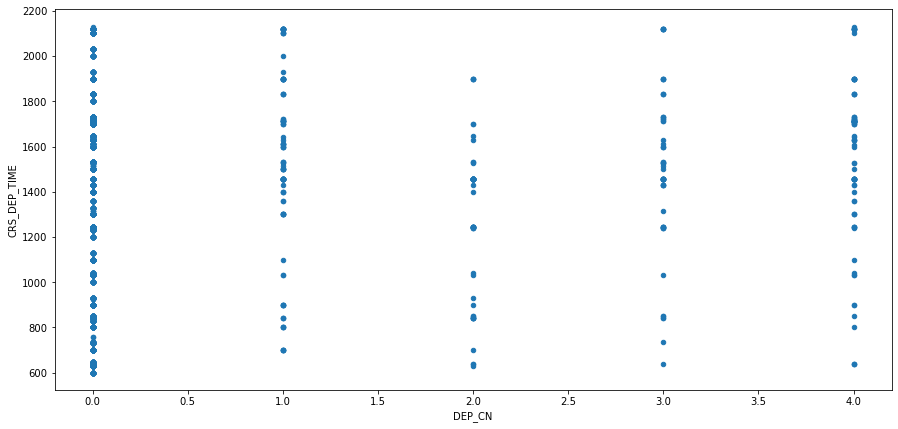

In [14]:
fig, ax = plt.subplots(figsize = (15,7))
flights.plot.scatter(x = "DEP_CN", y = "CRS_DEP_TIME", ax=ax)

In [29]:
y = flights["DEP_DIFF"]
X_baseline = flights[["CRS_DEP_TIME"]]

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()
print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:               DEP_DIFF   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.105
Date:                Sun, 14 Jan 2024   Prob (F-statistic):              0.147
Time:                        17:39:46   Log-Likelihood:                -12767.
No. Observations:                2201   AIC:                         2.554e+04
Df Residuals:                    2199   BIC:                         2.555e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           10.4875      5.671      1.849   

# Distance

In [28]:
y = flights["DEP_DIFF"]
X_baseline = flights[["DISTANCE"]]

baseline_model = sm.OLS(y, sm.add_constant(X_baseline))
baseline_results = baseline_model.fit()

print(baseline_results.summary())

                            OLS Regression Results                            
Dep. Variable:               DEP_DIFF   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7374
Date:                Sun, 14 Jan 2024   Prob (F-statistic):              0.391
Time:                        17:39:26   Log-Likelihood:                -12768.
No. Observations:                2201   AIC:                         2.554e+04
Df Residuals:                    2199   BIC:                         2.555e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.6729     27.201     -0.760      0.4

<AxesSubplot:xlabel='DEP_CN', ylabel='DISTANCE'>

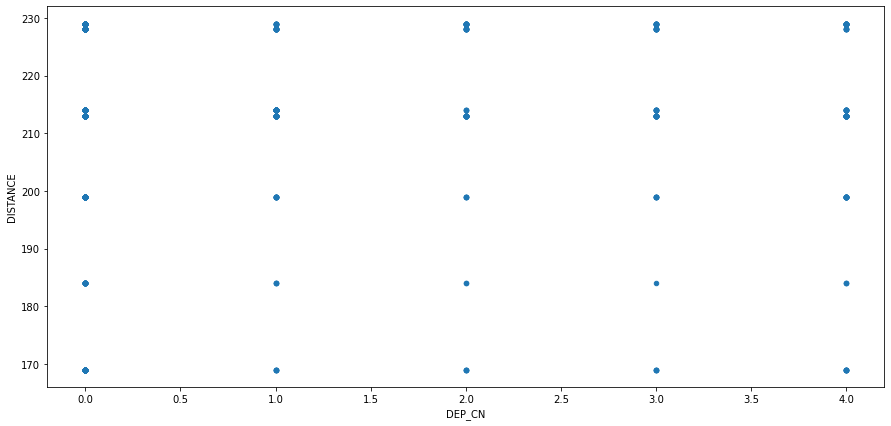

In [17]:
fig, ax = plt.subplots(figsize = (15,7))
flights.plot.scatter(x = "DEP_CN", y = "DISTANCE", ax=ax)

# Carrier

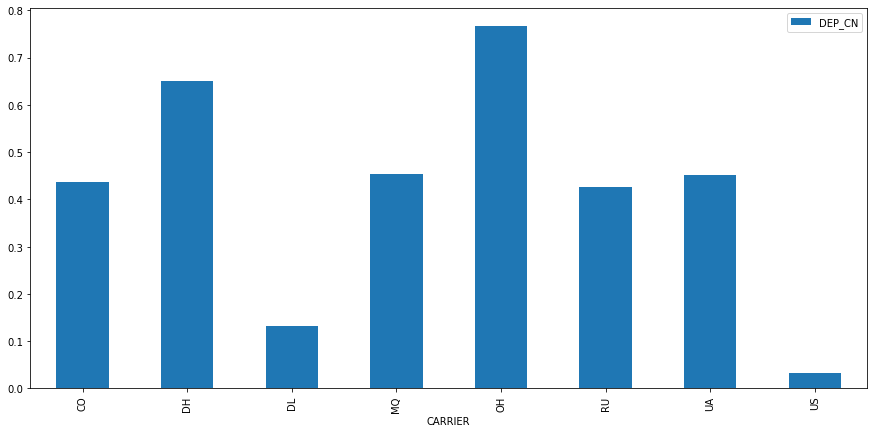

In [18]:
fig, ax = plt.subplots(figsize=(15,7))
flights.groupby("CARRIER").mean('DEP_CN').plot.bar(y='DEP_CN', ax=ax);

# Day of the Week

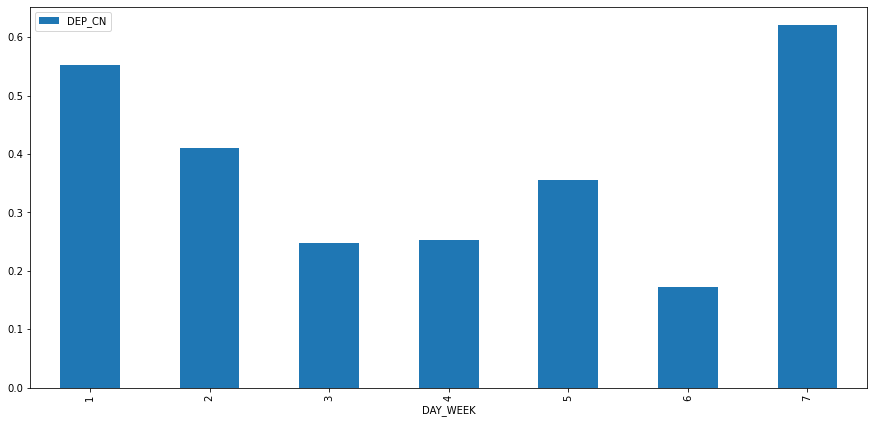

In [19]:
fig, ax = plt.subplots(figsize=(15,7))
flights.groupby("DAY_WEEK").mean('DEP_CN').plot.bar(y='DEP_CN', ax=ax);

# Flight Date

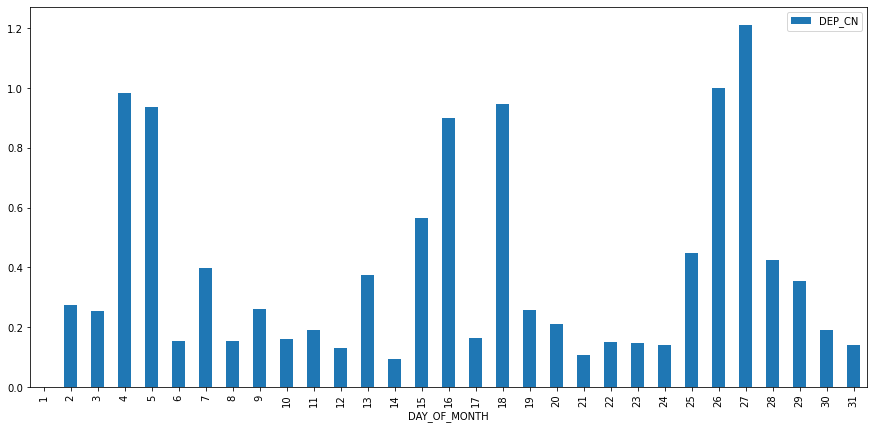

In [20]:
fig, ax = plt.subplots(figsize=(15,7))
flights.groupby("DAY_OF_MONTH").mean('DEP_CN').plot.bar(y='DEP_CN', ax=ax);

# MULTIPLE LINEAR REGRESSION

## Multiple Linear Regression: BASELINE
#### Purpose
For this first example, I want to create a baseline model. baseline being using every potential value in the data set.


In [21]:
#New data frame model
#["CRS_DEP_TIME", "CARRIER", 'DEST', 'DISTANCE', 'FL_DATE', "ORIGIN", "DAY_WEEK", "DEP_DIFF", "Flight Status"]
df_columns = ["CRS_DEP_TIME", "CARRIER", "DEP_TIME", 'DEST', 'DISTANCE', 'FL_DATE', "FL_NUM",  "ORIGIN", "Weather", "DAY_WEEK", "DAY_OF_MONTH", "TAIL_NUM", "DEP_DIFF"]
df = flights[df_columns]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201 entries, 0 to 2200
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CRS_DEP_TIME  2201 non-null   int64 
 1   CARRIER       2201 non-null   object
 2   DEP_TIME      2201 non-null   int64 
 3   DEST          2201 non-null   object
 4   DISTANCE      2201 non-null   int64 
 5   FL_DATE       2201 non-null   object
 6   FL_NUM        2201 non-null   int64 
 7   ORIGIN        2201 non-null   object
 8   Weather       2201 non-null   int64 
 9   DAY_WEEK      2201 non-null   int64 
 10  DAY_OF_MONTH  2201 non-null   int64 
 11  TAIL_NUM      2201 non-null   object
 12  DEP_DIFF      2201 non-null   int64 
dtypes: int64(8), object(5)
memory usage: 223.7+ KB


In [22]:
X = df.drop('DEP_DIFF', axis=1)
y = df['DEP_DIFF']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [23]:
#Separate categorical from data
numeric_features = ["CRS_DEP_TIME"]
categorical_features = ["CARRIER", 'DEST', 'DISTANCE', 'FL_DATE', "Weather"]
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#fit model to training data
model.fit(X_train, y_train)

#Predicting on the testing set
y_pred = model.predict(X_test)

#evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)
#
coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

print('Coefficients:', coefficients)
print('Intercept:', intercept)

Mean Squared Error: 3093.509366012081
R-squared: 0.19307009168815203
Coefficients: [ -2.00067818  29.34702241 -11.66429135 -17.55018013  -4.71901418
  -7.3508853   22.342467   -31.20811578  20.80299732 -10.97842623
  -3.55016575  14.52859198 -16.74489534  -7.3508853   -9.64296686
  11.33897744   6.10539112   7.87117809   8.42320086  18.02966476
   7.87474985   6.32221934 -28.92335799 -26.47996563   5.53856454
  -5.62060066   2.41641739   3.30890049   7.83007642   1.60250856
  11.10540641   0.28154377   4.57823402 -16.6837195  -36.59219623
   8.04946288 -23.68921433  35.98464106   5.6882008   11.42444529
   6.07804214  37.15731373  10.75756902  -1.42928258 -25.50147294
 -26.59882672  -5.80522376  -0.40144239   5.09234929   8.60499297
  28.99855147 -28.99855147]
Intercept: -35.09460252828575


#### Takeaway from the baseline
    -Origin and destination are interchangeable: having both does not improve the model
    -Flight date, day of the week, day of the month are also interchangeable
    -The absolute best mean square error is 3093
    -Flight number and tail number causes an error

In [24]:
df_columns = ["CRS_DEP_TIME", "CARRIER", 'DEST', 'DISTANCE', 'FL_DATE', "DAY_WEEK", "DAY_OF_MONTH", "DEP_DIFF"]
df = flights[df_columns]
df = pd.get_dummies(df, columns=["CARRIER", 'DEST'])

In [32]:
df.corr()["DEP_DIFF"]

CRS_DEP_TIME   -0.030928
DISTANCE        0.018309
DAY_WEEK       -0.006885
DAY_OF_MONTH    0.011836
DEP_DIFF        1.000000
CARRIER_CO      0.009573
CARRIER_DH     -0.131388
CARRIER_DL     -0.039657
CARRIER_MQ      0.022407
CARRIER_OH     -0.045016
CARRIER_RU     -0.009615
CARRIER_UA     -0.026158
CARRIER_US      0.192447
DEST_EWR       -0.052464
DEST_JFK       -0.094639
DEST_LGA        0.120283
Name: DEP_DIFF, dtype: float64

In [34]:
df_columns = ["Flight Status", "CRS_DEP_TIME", "CARRIER", 'DEST', 'DISTANCE', 'FL_DATE', "DEP_DIFF"]
df = flights[df_columns]
df_filtered = df[df['Flight Status'] != "ontime"]
df_filtered = df_filtered.drop("Flight Status", axis=1)
#df_filtered.head(20)
df_delayed = df_filtered
df_delayed = pd.get_dummies(df_delayed, columns=["CARRIER", 'DEST'])
df_delayed.head()

,CRS_DEP_TIME,DISTANCE,FL_DATE,DEP_DIFF,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_EWR,DEST_JFK,DEST_LGA
53,1455,229,01/02/2004,-76,0,1,0,0,0,0,0,0,0,0,1
56,1039,229,01/02/2004,-197,0,1,0,0,0,0,0,0,0,0,1
62,2120,228,01/02/2004,-185,0,1,0,0,0,0,0,0,0,1,0
96,1245,213,01/02/2004,-105,0,1,0,0,0,0,0,0,1,0,0
97,1430,213,01/02/2004,-82,0,1,0,0,0,0,0,0,1,0,0


In [35]:
df_delayed.corr()["DEP_DIFF"]

CRS_DEP_TIME    0.037712
DISTANCE        0.066038
DEP_DIFF        1.000000
CARRIER_CO      0.005937
CARRIER_DH     -0.040947
CARRIER_DL      0.043997
CARRIER_MQ     -0.001733
CARRIER_OH     -0.051834
CARRIER_RU     -0.044879
CARRIER_UA     -0.034583
CARRIER_US      0.116366
DEST_EWR       -0.088889
DEST_JFK       -0.049890
DEST_LGA        0.127090
Name: DEP_DIFF, dtype: float64

## Multiple Linear Regression: Filters
#### Filter 1: Filter out any values that were not delayed. 
    -Noted as df_delayed

In [72]:
df_columns = ["Flight Status", "CRS_DEP_TIME", "CARRIER", 'DEST', 'DISTANCE', 'FL_DATE', "Weather", "DEP_DIFF"]
df = flights[df_columns]
df_filtered = df[df['Flight Status'] != "ontime"]
df_filtered = df_filtered.drop("Flight Status", axis=1)
#df_filtered.head(20)
df_delayed = df_filtered
df_delayed.head()

,CRS_DEP_TIME,CARRIER,DEST,DISTANCE,FL_DATE,Weather,DEP_DIFF
53,1455,DH,LGA,229,01/02/2004,0,-76
56,1039,DH,LGA,229,01/02/2004,0,-197
62,2120,DH,JFK,228,01/02/2004,0,-185
96,1245,DH,EWR,213,01/02/2004,0,-105
97,1430,DH,EWR,213,01/02/2004,0,-82


In [73]:
X = df_delayed.drop('DEP_DIFF', axis=1)
y = df_delayed['DEP_DIFF']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Separate categorical from data
numeric_features = ["CRS_DEP_TIME"]
categorical_features = ["CARRIER", 'DEST', 'DISTANCE', 'FL_DATE', "Weather"]
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#fit model to training data
model.fit(X_train, y_train)

#Predicting on the testing set
y_pred = model.predict(X_test)

#evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_
print('Coefficients:', coefficients)
print('Intercept:', intercept)

Mean Squared Error: 8138.978415788853
R-squared: -0.6084455783085685
Coefficients: [ 10.65549082  85.19003357 -25.78838386  -8.37367519 -33.36501804
 -15.08627941  54.25256474 -78.70462387  21.87538206 -37.17675703
  -3.96989967  41.1466567  -25.65979394 -15.08627941 -45.92765256
  13.26767517   6.63619433  32.25939405  34.51046236 -61.12272191
 -11.26424811 -84.95079467 -54.34295324   5.21526558  -8.97739923
 -43.95262647 -34.60127606   8.12964925 -15.51690477  11.57532211
 -48.0067239    6.09304754  -7.38140624 -42.19769253  -6.62165649
 -18.26004431 175.44153382 -15.83010231  23.16531568 -22.04691514
 283.72152585  49.80780653  -9.22529047 -46.26115729 -21.59683356
  13.76330609 -21.12371599   3.6247996   -7.25710936   9.16898883
  -9.16898883]
Intercept: -57.79018363370672


#### Delayed only flights, replacing everything positive with the negative average

In [74]:
df_delayed['DEP_DIFF'].unique()

array([ -76, -197, -185, -105,  -82,    5,  -93,  -50,  -70,  -17,  -84,
       -150,  -80, -122,   -4,  -28,   42,  -36, -160, -101, -425, -205,
       -203, -207,  -65, -170, -222, -210,   44, -220,  -42, -155,    2,
       -151, -133,    7, -106,  -72,  -41,  -25,  -27,  -49,    3,  -44,
       -191,  -24, -116, -112, -192, -156,  -21,  -54, -204,  -87,  -92,
        -33,  -35,   -9,  -10,   -1, -119,  -98,  -88,   43, -114,    0,
         41, -200,  -14,  -48,  -83,  -75,  -31,  -55, -251, -146,  -16,
       -153, -391,  -74,    4,  -43,  -18,  -78,  -63,   45,   46,   -2,
        -15,  -32, -100, -111, -107,  -86, -310,  -11,  -90,  -13,    1,
        -58,  -91,  -51,  -52,  -45,  -40,  -56, -237, -189,   53, -117,
        -29, -129,  -23, -145, -123, -182, -102,  -97, -190, -121, -127,
       -110,   -5,   -8,  -19,  -71,    6,  -96,   48, -193,  -30, -118,
       -104,  -73, -124,  -59, -130, -263, 2110,  -22,  -34,  -37, -180,
         -3,  -62,   -6,    8,  -85,  -79,  -39,   

In [75]:
negative_numbers = df_delayed[df_delayed['DEP_DIFF'] < 0]['DEP_DIFF']
average_negative = negative_numbers.mean()
print(f'Average of negative numbers: {average_negative}')
average_negative = -85

Average of negative numbers: -85.57099697885197


In [76]:
df_delayed['DEP_DIFF'] = df_delayed['DEP_DIFF'].apply(lambda x: average_negative if x > -15 else x)

In [77]:
df_delayed['DEP_DIFF'].unique()

array([ -76, -197, -185, -105,  -82,  -85,  -93,  -50,  -70,  -17,  -84,
       -150,  -80, -122,  -28,  -36, -160, -101, -425, -205, -203, -207,
        -65, -170, -222, -210, -220,  -42, -155, -151, -133, -106,  -72,
        -41,  -25,  -27,  -49,  -44, -191,  -24, -116, -112, -192, -156,
        -21,  -54, -204,  -87,  -92,  -33,  -35, -119,  -98,  -88, -114,
       -200,  -48,  -83,  -75,  -31,  -55, -251, -146,  -16, -153, -391,
        -74,  -43,  -18,  -78,  -63,  -15,  -32, -100, -111, -107,  -86,
       -310,  -90,  -58,  -91,  -51,  -52,  -45,  -40,  -56, -237, -189,
       -117,  -29, -129,  -23, -145, -123, -182, -102,  -97, -190, -121,
       -127, -110,  -19,  -71,  -96, -193,  -30, -118, -104,  -73, -124,
        -59, -130, -263,  -22,  -34,  -37, -180,  -62,  -79,  -39, -167,
       -157, -232, -361,  -89, -126, -217,  -20, -307, -256, -230, -301,
       -164,  -57, -120, -212, -255, -176, -103, -128, -109, -154, -224,
        -81,  -46,  -95,  -94], dtype=int64)

In [78]:
X = df_delayed.drop('DEP_DIFF', axis=1)
y = df_delayed['DEP_DIFF']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Separate categorical from data
numeric_features = ["CRS_DEP_TIME"]
categorical_features = ["CARRIER", 'DEST', 'DISTANCE', 'FL_DATE', "Weather"]
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#fit model to training data
model.fit(X_train, y_train)

#Predicting on the testing set
y_pred = model.predict(X_test)

#evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_
print('Coefficients:', coefficients)
print('Intercept:', intercept)

Mean Squared Error: 2694.9245096342515
R-squared: -0.21762366513967857
Coefficients: [ -2.06169984  31.14823481 -36.79624517   7.79110498  17.20733557
 -13.6650996   -8.72837386 -13.7206617   16.76370497   5.5694323
  -4.5136806   -1.0557517  -13.27370566 -13.6650996  -18.24805873
   3.66505694  -3.60756113  42.57755873   2.55180944 -28.7194848
  11.41764464 -60.22900127 -12.5251956   10.03207191   9.27314829
 -11.5494282   -4.80758738  21.54143073 -12.46493684   4.06123891
 -13.32035228 -12.09673367   7.68175741 -22.68703801  19.90772205
  -3.96439749  -2.78394385   6.04745092  28.3803309   11.46417334
   3.62911157  13.16868367   0.79500875 -10.07799958  -4.75550548
  32.39676525  12.99052639  16.1098555   -8.91531577   6.93065732
  -6.93065732]
Intercept: -91.2269740866558


#### Doing the same, but dropping anything with a a value above -15

In [86]:
df_columns = ["Flight Status", "CRS_DEP_TIME", "CARRIER", 'DEST', 'DISTANCE', 'FL_DATE', "DEP_DIFF"]
df = flights[df_columns]
df_filtered = df[df['Flight Status'] != "ontime"]
df_filtered = df_filtered.drop("Flight Status", axis=1)
#df_filtered.head(20)
df_delayed = df_filtered
df_delayed['DEP_DIFF'].unique()

array([ -76, -197, -185, -105,  -82,    5,  -93,  -50,  -70,  -17,  -84,
       -150,  -80, -122,   -4,  -28,   42,  -36, -160, -101, -425, -205,
       -203, -207,  -65, -170, -222, -210,   44, -220,  -42, -155,    2,
       -151, -133,    7, -106,  -72,  -41,  -25,  -27,  -49,    3,  -44,
       -191,  -24, -116, -112, -192, -156,  -21,  -54, -204,  -87,  -92,
        -33,  -35,   -9,  -10,   -1, -119,  -98,  -88,   43, -114,    0,
         41, -200,  -14,  -48,  -83,  -75,  -31,  -55, -251, -146,  -16,
       -153, -391,  -74,    4,  -43,  -18,  -78,  -63,   45,   46,   -2,
        -15,  -32, -100, -111, -107,  -86, -310,  -11,  -90,  -13,    1,
        -58,  -91,  -51,  -52,  -45,  -40,  -56, -237, -189,   53, -117,
        -29, -129,  -23, -145, -123, -182, -102,  -97, -190, -121, -127,
       -110,   -5,   -8,  -19,  -71,    6,  -96,   48, -193,  -30, -118,
       -104,  -73, -124,  -59, -130, -263, 2110,  -22,  -34,  -37, -180,
         -3,  -62,   -6,    8,  -85,  -79,  -39,   

In [87]:
df_delayed = df_delayed[df_delayed['DEP_DIFF'] <= -15]
df_delayed['DEP_DIFF'].unique()

array([ -76, -197, -185, -105,  -82,  -93,  -50,  -70,  -17,  -84, -150,
        -80, -122,  -28,  -36, -160, -101, -425, -205, -203, -207,  -65,
       -170, -222, -210, -220,  -42, -155, -151, -133, -106,  -72,  -41,
        -25,  -27,  -49,  -44, -191,  -24, -116, -112, -192, -156,  -21,
        -54, -204,  -87,  -92,  -33,  -35, -119,  -98,  -88, -114, -200,
        -48,  -83,  -75,  -31,  -55, -251, -146,  -16, -153, -391,  -74,
        -43,  -18,  -78,  -63,  -15,  -32, -100, -111, -107,  -86, -310,
        -90,  -58,  -91,  -51,  -52,  -45,  -40,  -56, -237, -189, -117,
        -29, -129,  -23, -145, -123, -182, -102,  -97, -190, -121, -127,
       -110,  -19,  -71,  -96, -193,  -30, -118, -104,  -73, -124,  -59,
       -130, -263,  -22,  -34,  -37, -180,  -62,  -85,  -79,  -39, -167,
       -157, -232, -361,  -89, -126, -217,  -20, -307, -256, -230, -301,
       -164,  -57, -120, -212, -255, -176, -103, -128, -109, -154, -224,
        -81,  -46,  -95,  -94], dtype=int64)

In [88]:
X = df_delayed.drop('DEP_DIFF', axis=1)
y = df_delayed['DEP_DIFF']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#Separate categorical from data
numeric_features = ["CRS_DEP_TIME"]
categorical_features = ["CARRIER", 'DEST', 'DISTANCE', 'FL_DATE']
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#fit model to training data
model.fit(X_train, y_train)

#Predicting on the testing set
y_pred = model.predict(X_test)

#evaluating the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_
print('Coefficients:', coefficients)
print('Intercept:', intercept)

Mean Squared Error: 8021.916063174698
R-squared: 0.015950575890196217
Coefficients: [-1.57757356e+00  3.06784805e+01 -4.88142085e+01  1.92932927e+01
  1.98247834e+01 -1.57355878e+01 -2.32545276e+01 -4.12772578e+01
  5.92850251e+01  2.02831223e+01 -2.16513286e+01  1.36820630e+00
 -1.36390051e+01 -1.57355878e+01 -4.83979276e+01  2.92811242e+00
 -1.00009744e+01  7.34762017e+01  1.13691807e+01 -3.07662370e+01
  4.17603741e+01 -3.94119335e+01 -5.50680378e+00  2.13163143e+01
  4.07312394e+00 -2.60453604e+01  1.90052809e+01  7.11765415e+00
 -3.95239610e+01  1.01744468e-02 -1.67360709e+01 -7.34322549e+00
  1.88779206e+01 -2.72304039e+01  1.67030614e+01 -6.38360754e+00
 -9.56282382e+00  1.21187237e+01  5.53617238e+01  1.87913825e+01
 -2.17741053e+01  2.35969176e+01 -7.04342995e+00 -3.70174221e+00
 -2.86716784e+01  7.44932471e+00  1.79748735e+01  2.80053271e+01
 -2.24607934e+01]
Intercept: -74.34305139439607


#### Filter 1: Logarithm transformation

In [49]:
df_columns = ["CRS_DEP_TIME", "CARRIER", 'DEST', 'DISTANCE', "DAY_WEEK", "DAY_OF_MONTH", "DEP_DIFF"]
df = flights[df_columns]
df = pd.get_dummies(df, columns=["CARRIER", 'DEST'])


In [50]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import FunctionTransformer

# Assume df is your DataFrame, and 'MinutesDelayed' is the target variable
# and 'Feature1', 'Feature2', ... are your predictors

# Extract the target variable and predictors
X = df.drop("DEP_DIFF", axis=1)
y = df["DEP_DIFF"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a logarithmic transformation function
log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1)

# Apply the logarithmic transformation to the target variable
y_train_log = log_transformer.transform(y_train)
y_test_log = log_transformer.transform(y_test)

# Apply the logarithmic transformation to relevant predictors if needed
# X_train_log = log_transformer.transform(X_train['Feature1'])
# X_test_log = log_transformer.transform(X_test['Feature1'])

# Train your model using the transformed target variable
model = LinearRegression()
model.fit(X_train, y_train_log)

# Predict on the test set
y_pred_log = model.predict(X_test)

# Inverse transform the predictions to get them back to the original scale
y_pred = log_transformer.inverse_transform(y_pred_log)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f'R-squared after logarithmic transformation: {r2}')

C:\Users\aruizmartinez\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\aruizmartinez\AppData\Local\anaconda3\envs\learn-env\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

# Gradient Boosting Regressor: Baseline

In [201]:
#we need dummy variables for this one
df_columns = ['DISTANCE',"DEP_DIFF", "CARRIER", 'DEST']
df = flights[df_columns]
df = pd.get_dummies(df, columns=["CARRIER", 'DEST'])

In [202]:
X = df.drop('DEP_DIFF', axis=1)
y = df['DEP_DIFF']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a GradientBoostingRegressor model
model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 3376.635735825289
R-squared: 0.11921767729299038


In [203]:
df_columns = ["Flight Status", 'DISTANCE',"DEP_DIFF", "CARRIER", 'DEST']
df = flights[df_columns]
df = pd.get_dummies(df, columns=["CARRIER", 'DEST'])

df_filtered = df[df['Flight Status'] != "ontime"]
df_filtered = df_filtered.drop("Flight Status", axis=1)
#df_filtered.head(20)
df_delayed = df_filtered
df_delayed.head()

,DISTANCE,DEP_DIFF,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US,DEST_EWR,DEST_JFK,DEST_LGA
53,229,-76,0,1,0,0,0,0,0,0,0,0,1
56,229,-197,0,1,0,0,0,0,0,0,0,0,1
62,228,-185,0,1,0,0,0,0,0,0,0,1,0
96,213,-105,0,1,0,0,0,0,0,0,1,0,0
97,213,-82,0,1,0,0,0,0,0,0,1,0,0


In [204]:
X = df_delayed.drop('DEP_DIFF', axis=1)
y = df_delayed['DEP_DIFF']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a GradientBoostingRegressor model
model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 4396.038189987123
R-squared: 0.1312437719402566


In [186]:
#New data frame model
#["CRS_DEP_TIME", "CARRIER", 'DEST', 'DISTANCE', 'FL_DATE', "ORIGIN", "DAY_WEEK", "DEP_DIFF", "Flight Status"]
df_columns = ["CRS_DEP_TIME", "CARRIER", "DAY_WEEK", "DEP_DIFF", "Flight Status"]
df = flights[df_columns]
#df_filtered = df[df['Flight Status'] != "ontime"]
#df_filtered = df_filtered.drop("Flight Status", axis=1)
#df_filtered.head(20)
df_filtered = df
df.head()


,CRS_DEP_TIME,CARRIER,DAY_WEEK,DEP_DIFF,Flight Status
0,1455,OH,4,0,ontime
1,1640,DH,4,0,ontime
2,1245,DH,4,0,ontime
3,1715,DH,4,6,ontime
4,1039,DH,4,4,ontime


In [187]:
# Use pd.get_dummies to create dummy variables
df_dummies = pd.get_dummies(df_filtered['Flight Status'], prefix='Flight Status')

# Concatenate the dummy variables with the original DataFrame
df_filtered = pd.concat([df, df_dummies], axis=1)

# Drop the original categorical column if needed
df_filtered = df_filtered.drop('Flight Status', axis=1)

df = df_filtered

df.head()

,CRS_DEP_TIME,CARRIER,DAY_WEEK,DEP_DIFF,Flight Status_delayed,Flight Status_ontime
0,1455,OH,4,0,0,1
1,1640,DH,4,0,0,1
2,1245,DH,4,0,0,1
3,1715,DH,4,6,0,1
4,1039,DH,4,4,0,1


In [188]:
df.corr()

,CRS_DEP_TIME,DAY_WEEK,DEP_DIFF,Flight Status_delayed,Flight Status_ontime
CRS_DEP_TIME,1.000000,0.051766,-0.030928,0.112474,-0.112474
DAY_WEEK,0.051766,1.000000,-0.006885,-0.040756,0.040756
DEP_DIFF,-0.030928,-0.006885,1.000000,-0.332417,0.332417
Flight Status_delayed,0.112474,-0.040756,-0.332417,1.000000,-1.000000
Flight Status_ontime,-0.112474,0.040756,0.332417,-1.000000,1.000000


In [189]:
# Use pd.get_dummies to create dummy variables
df_dummies = pd.get_dummies(df_filtered['CARRIER'], prefix='CARRIER')

# Concatenate the dummy variables with the original DataFrame
df_filtered = pd.concat([df, df_dummies], axis=1)

# Drop the original categorical column if needed
df_filtered = df_filtered.drop('CARRIER', axis=1)

df = df_filtered

df.head()

,CRS_DEP_TIME,DAY_WEEK,DEP_DIFF,Flight Status_delayed,Flight Status_ontime,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US
0,1455,4,0,0,1,0,0,0,0,1,0,0,0
1,1640,4,0,0,1,0,1,0,0,0,0,0,0
2,1245,4,0,0,1,0,1,0,0,0,0,0,0
3,1715,4,6,0,1,0,1,0,0,0,0,0,0
4,1039,4,4,0,1,0,1,0,0,0,0,0,0


In [190]:
df.corr()

,CRS_DEP_TIME,DAY_WEEK,DEP_DIFF,Flight Status_delayed,Flight Status_ontime,CARRIER_CO,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US
CRS_DEP_TIME,1.000000,0.051766,-0.030928,0.112474,-0.112474,0.023222,0.102504,-0.002748,-0.053631,0.022571,-0.030286,-0.144207,-0.009396
DAY_WEEK,0.051766,1.000000,-0.006885,-0.040756,0.040756,-0.017852,0.025394,-0.010861,-0.023916,0.007898,0.029223,0.012015,-0.022712
DEP_DIFF,-0.030928,-0.006885,1.000000,-0.332417,0.332417,0.009573,-0.131388,-0.039657,0.022407,-0.045016,-0.009615,-0.026158,0.192447
Flight Status_delayed,0.112474,-0.040756,-0.332417,1.000000,-1.000000,0.043835,0.079110,-0.085704,0.076270,-0.018155,0.043311,-0.010016,-0.129174
Flight Status_ontime,-0.112474,0.040756,0.332417,-1.000000,1.000000,-0.043835,-0.079110,0.085704,-0.076270,0.018155,-0.043311,0.010016,0.129174
CARRIER_CO,0.023222,-0.017852,0.009573,0.043835,-0.043835,1.000000,-0.122058,-0.097712,-0.083096,-0.024829,-0.100756,-0.025245,-0.100149
CARRIER_DH,0.102504,0.025394,-0.131388,0.079110,-0.079110,-0.122058,1.000000,-0.267332,-0.227344,-0.067930,-0.275660,-0.069069,-0.274000
CARRIER_DL,-0.002748,-0.010861,-0.039657,-0.085704,0.085704,-0.097712,-0.267332,1.000000,-0.181998,-0.054381,-0.220677,-0.055293,-0.219348
CARRIER_MQ,-0.053631,-0.023916,0.022407,0.076270,-0.076270,-0.083096,-0.227344,-0.181998,1.000000,-0.046247,-0.187668,-0.047022,-0.186538
CARRIER_OH,0.022571,0.007898,-0.045016,-0.018155,0.018155,-0.024829,-0.067930,-0.054381,-0.046247,1.000000,-0.056075,-0.014050,-0.055737


In [ ]:
#Separate categorical from data
numeric_features = ["CRS_DEP_TIME"]
categorical_features = ["CARRIER", 'DEST', 'DISTANCE', "ORIGIN", "DAY_WEEK"]
# Define preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Create the pipeline with preprocessing and model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

#fit model to training data
model.fit(X_train, y_train)

#Predicting on the testing set
y_pred = model.predict(X_test)

#evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

#
coefficients = model.named_steps['regressor'].coef_
intercept = model.named_steps['regressor'].intercept_

print('Coefficients:', coefficients)
print('Intercept:', intercept)

In [199]:
feedback = pd.read_csv("../../sample_project/feedback.csv")
feedback.head()

,satisfaction,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,...,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
0,satisfied,Female,Loyal Customer,65,Personal Travel,Eco,265,0,0,0,...,2,3,3,0,3,5,3,2,0,0.0
1,satisfied,Male,Loyal Customer,47,Personal Travel,Business,2464,0,0,0,...,2,3,4,4,4,2,3,2,310,305.0
2,satisfied,Female,Loyal Customer,15,Personal Travel,Eco,2138,0,0,0,...,2,2,3,3,4,4,4,2,0,0.0
3,satisfied,Female,Loyal Customer,60,Personal Travel,Eco,623,0,0,0,...,3,1,1,0,1,4,1,3,0,0.0
4,satisfied,Female,Loyal Customer,70,Personal Travel,Eco,354,0,0,0,...,4,2,2,0,2,4,2,5,0,0.0


In [201]:
feedback.corr()

,Age,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes
Age,1.000000,-0.249625,0.008784,0.039055,0.015749,-0.000547,0.013965,0.130511,0.121201,0.071594,0.066704,0.083762,-0.015452,0.031845,-0.018271,0.037973,-0.009041,-0.011248
Flight Distance,-0.249625,1.000000,-0.042409,0.001350,-0.004649,-0.002409,0.012230,-0.027542,-0.032022,-0.022299,-0.032559,-0.030316,0.019768,0.002456,0.009432,0.009604,0.112555,0.110103
Seat comfort,0.008784,-0.042409,1.000000,0.434951,0.715997,0.405300,0.129131,0.426447,0.120278,0.211531,0.121149,0.136136,0.118489,0.041214,0.108475,0.130396,-0.023817,-0.025506
Departure/Arrival time convenient,0.039055,0.001350,0.434951,1.000000,0.527381,0.544259,-0.001974,0.077203,-0.000546,0.001755,0.060446,0.029422,0.067396,0.062794,0.067126,-0.000623,0.004395,0.002599
Food and drink,0.015749,-0.004649,0.715997,0.527381,1.000000,0.523328,0.025917,0.367669,0.028554,0.041189,0.038646,0.074161,0.036370,0.011898,0.033416,0.013587,-0.013433,-0.014881
Gate location,-0.000547,-0.002409,0.405300,0.544259,0.523328,1.000000,-0.004086,-0.000280,0.002908,0.001442,-0.025132,-0.007407,-0.000401,-0.031859,-0.001705,-0.003043,0.003962,0.003640
Inflight wifi service,0.013965,0.012230,0.129131,-0.001974,0.025917,-0.004086,1.000000,0.253823,0.557340,0.601100,0.060794,0.033589,0.038251,0.092508,0.038263,0.631786,-0.032900,-0.035270
Inflight entertainment,0.130511,-0.027542,0.426447,0.077203,0.367669,-0.000280,0.253823,1.000000,0.441957,0.321731,0.183912,0.160731,0.117213,0.224120,0.109451,0.355714,-0.030491,-0.033321
Online support,0.121201,-0.032022,0.120278,-0.000546,0.028554,0.002908,0.557340,0.441957,1.000000,0.617489,0.157930,0.138433,0.102444,0.206824,0.095726,0.669843,-0.034018,-0.036087
Ease of Online booking,0.071594,-0.022299,0.211531,0.001755,0.041189,0.001442,0.601100,0.321731,0.617489,1.000000,0.436264,0.355122,0.398322,0.137744,0.417675,0.684320,-0.036545,-0.039806
